## Dependencies

In [1]:
!nvidia-smi
!jupyter notebook list
%env CUDA_VISIBLE_DEVICES=0,1

Tue Dec  3 03:07:55 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.104      Driver Version: 410.104      CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8    27W / 149W |     11MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00000000:00:05.0 Off |                    0 |
| N/A   40C    P8    31W / 149W |     11MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [8]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import time
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from models import DilatedDense
from datasets import deepglobe
from datasets import madg
from datasets import joint_transforms
import utils.imgs
import utils.training as train_utils

# tensorboard
from torch.utils.tensorboard import SummaryWriter

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset

- Download the DeepGlobe dataset from https://competitions.codalab.org/competitions/18467. Place it in datasets/deepglobe/dataset/train,test,valid
- Download the Massachusetts Road Dataset from https://www.cs.toronto.edu/~vmnih/data/. Combine the training, validation, and test sets, process with `crop_dataset.ipynb` and place the output in datasets/maroads/dataset/map,sat
- Run `combine_datasets.ipynb` to combine the two and output to datasets/madg

In [79]:
run = "expDilatedDense.1"
DEEPGLOBE_PATH = Path('datasets/', 'deepglobe/dataset')
MADG_PATH = Path('datasets/', 'madg/dataset')
RESULTS_PATH = Path('.results/')
WEIGHTS_PATH = Path('.weights/') / run
RUNS_PATH    = Path('.runs/')
RESULTS_PATH.mkdir(exist_ok=True)
WEIGHTS_PATH.mkdir(exist_ok=True)
RUNS_PATH.mkdir(exist_ok=True)

batch_size = 1 # TODO: Should be `MAX_BATCH_PER_CARD * torch.cuda.device_count()` (which in this case is 1 assuming max of 1 batch per card)

In [80]:
# resize = joint_transforms.JointRandomCrop((300, 300))

# normalize = transforms.Normalize(mean=deepglobe.mean, std=deepglobe.std)
# normalize = transforms.Normalize(mean=madg.mean, std=madg.std)

# Convert to BGR to be compatible with Fair's training
rgb_to_bgr = transforms.Lambda(lambda x: x[[2, 1, 0]])



train_joint_transformer = transforms.Compose([
#     resize,  
    joint_transforms.JointRandomHorizontalFlip(),
    joint_transforms.JointRandomVerticalFlip(),
    joint_transforms.JointRandomRotate()
    ])

train_dset = madg.Madg(MADG_PATH, 'train', # 'rgb',
    joint_transform=train_joint_transformer,
    transform=transforms.Compose([
#         transforms.ColorJitter(brightness=.4,contrast=.4,saturation=.4),
        transforms.ToTensor(),
        rgb_to_bgr

#         normalize,
    ]))

train_loader = torch.utils.data.DataLoader(
    train_dset, batch_size=batch_size, shuffle=True)





resize_joint_transformer = None
val_dset = madg.Madg(
    MADG_PATH, 'valid', joint_transform=resize_joint_transformer,
    transform=transforms.Compose([
        transforms.ToTensor(),
        rgb_to_bgr
#         normalize
    ]))
val_loader = torch.utils.data.DataLoader(
    val_dset, batch_size=batch_size, shuffle=False)

test_dset = madg.Madg(
    MADG_PATH, 'test', joint_transform=resize_joint_transformer,
    transform=transforms.Compose([
        transforms.ToTensor(),
        rgb_to_bgr
#         normalize
    ]))
test_loader = torch.utils.data.DataLoader(
    test_dset, batch_size=batch_size, shuffle=False)

Train: 4771
Val: 1182
Test: 1182
Inputs:  torch.Size([1, 3, 1024, 1024])
Targets:  torch.Size([1, 1024, 1024])


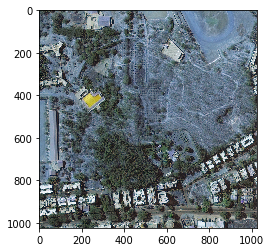

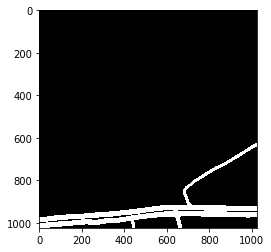

tensor(1.) tensor(0.)
tensor(1, dtype=torch.int32) tensor(0, dtype=torch.int32)


In [81]:
print("Train: %d" %len(train_loader.dataset))
print("Val: %d" %len(val_loader.dataset.imgs))
print("Test: %d" %len(test_loader.dataset.imgs))

# print("Classes: %d" % len(train_loader.dataset.classes))

print((iter(train_loader)))

inputs, targets = next(iter(train_loader))
print("Inputs: ", inputs.size())
print("Targets: ", targets.size())

utils.imgs.view_image(inputs[0])
# utils.imgs.view_image(targets[0])
utils.imgs.view_annotated(targets[0])

print(inputs[0].max(),inputs[0].min())
print(targets[0].max(),targets[0].min())



## Train

In [82]:
LR = 1e-4
LR_DECAY = 0.995
DECAY_EVERY_N_EPOCHS = 1
N_EPOCHS = 1000
torch.cuda.manual_seed(0)

In [83]:
from utils.bceloss import dice_bce_loss
from loss.BCESSIM import BCESSIM

torch.cuda.set_device(0)
print(torch.cuda.device_count())
model = DilatedDense.DilatedDense().cuda()
ids = [0]
model = torch.nn.DataParallel(model, device_ids=ids).cuda()

optimizer = torch.optim.RMSprop(model.parameters(), lr=LR, weight_decay=1e-4)

# criterion = dice_bce_loss()
criterion = BCESSIM()

# summary(model, input_size=inputs[0].shape)

2


In [84]:
start_epoch = 0
!ls -l {WEIGHTS_PATH/'latest.th'}
start_epoch = train_utils.load_weights_fair(model, (WEIGHTS_PATH/'latest.th'), map_location={'cuda:2':'cuda:0'})

print("Starting from epoch", start_epoch)

-rw-r--r-- 1 jupyter jupyter 2548229 Dec  1 01:52 .weights/expDilatedDense.1/latest.th
loading weights '.weights/expDilatedDense.1/latest.th'
loaded weights (lastEpoch -1, loss ?, error ?)
Starting from epoch -1


In [85]:
# Writer will output to ./runs/ directory by default
writer = SummaryWriter(log_dir=(RUNS_PATH.as_posix() + "/" + "run" + str(run) + "/"))

In [86]:
from torch.autograd import Variable
start_epoch = 80
debug_max_size=None

# break # errors. Used to stop "run all"
for epoch in range(start_epoch, N_EPOCHS+1):
    since = time.time()

#     ### Train ###
#     trn_loss, trn_err = train_utils.train(
#         model, train_loader, optimizer, criterion, epoch, debug_max_size=debug_max_size)
#     print('Epoch {:d}\nTrain - Loss: {:.4f}, Acc: {:.4f}'.format(
#         epoch, trn_loss, 1-trn_err))    
#     time_elapsed = time.time() - since  
#     print('Train Time {:.0f}m {:.0f}s'.format(
#         time_elapsed // 60, time_elapsed % 60))
    
    ### Validation ###
    tes_loss, tes_err, tes_iou = train_utils.test(model, val_loader, criterion, epoch, debug_max_size=debug_max_size)    
    print("err",tes_err)
    print("jac",tes_iou)
    print('Tes - Loss: {:.4f} | Acc: {:.4f} | Jacc: {:.4f}'.format(tes_loss, 1-tes_err, tes_iou))
    time_elapsed = time.time() - since  
    print('Total Time {:.0f}m {:.0f}s\n'.format(
        time_elapsed // 60, time_elapsed % 60))
    
#     val_loss = trn_loss
#     val_err = trn_err
    
    ### Checkpoint ###    
#     train_utils.save_weights(model, epoch, tes_loss, tes_err, WEIGHTS_PATH=WEIGHTS_PATH)

    ### Adjust Lr ###
#     train_utils.adjust_learning_rate(LR, LR_DECAY, optimizer, 
#                                      epoch, DECAY_EVERY_N_EPOCHS)
    
#     # Log on tensorboard
# #     writer.add_scalar('Loss/train', trn_loss, epoch)
#     writer.add_scalar('Loss/val', tes_loss, epoch)
    
# #     writer.add_scalar('Error/train', trn_err, epoch)
#     writer.add_scalar('Error/val', tes_err, epoch)
    
# #     writer.add_scalar('Accuracy/train', 1-trn_err, epoch)
#     writer.add_scalar('Accuracy/val', tes_iou, epoch)
    
# #     writer.add_scalar('Accuracy/train', epoch_acc, epoch)
# #     writer.add_scalar('Accuracy/test/noaug', do_valid(False), epoch)
# #     writer.add_scalar('Accuracy/test/tta', do_valid(True), epoch)
#     for param_group in optimizer.param_groups:
#         writer.add_scalar('Params/learning_rage', param_group['lr'], epoch)
# #     writer.add_scalar('params/learning_rate', optimizer.lr, epoch)
# #     writer.add_scalar('Params/no_optim', no_optim, epoch)

#     # log a sample image
# #     sample_images = [0,1030,281,623,636,655,1028,1353,2222,2224]
#     sample_images = [0,1030,281,623,636,655,1028,1000,1001,1002]

#     for i in sample_images:
#         inputs, targets, pred, loss, err, iou = train_utils.get_sample_predictions(model, val_loader, n=1, criterion=criterion, idx=i)
#         raw = model(inputs.cuda()).cpu()        
#         img = torchvision.utils.make_grid(torch.stack([
#             inputs[0],
#             targets[0].unsqueeze(0).expand(3,-1,-1).float(), 
#             pred[0].unsqueeze(0).expand(3,-1,-1).float(),
#             raw[0].expand(3,-1,-1).float()
#         ]), normalize=True)
        
#         writer.add_image('sample_pred/val/' + str(i), img, epoch)
    
    start_epoch = epoch

err 0.4674947008088407
jac 0.5325052991911589
Tes - Loss: 0.1621 | Acc: 0.5325 | Jacc: 0.5325
Total Time 6m 17s

err 0.4674947008088407
jac 0.5325052991911589
Tes - Loss: 0.1621 | Acc: 0.5325 | Jacc: 0.5325
Total Time 6m 17s

err 0.4674947008088407
jac 0.5325052991911589
Tes - Loss: 0.1621 | Acc: 0.5325 | Jacc: 0.5325
Total Time 6m 16s



KeyboardInterrupt: 


## Test

In [ ]:
# returns test_loss, test_error, jaccard
train_utils.test(model, val_loader, criterion, epoch=1)

In [ ]:
stats = train_utils.view_sample_predictions(model, val_loader, n=1, criterion=criterion)
print("loss", "error", "jaccard")
print(stats)


In [ ]:
# !pip install torchsummary
from torchsummary import summary
summary(model, input_size=inputs[0].shape)